In [2]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
import os

In [5]:
load_dotenv()

llm = ChatGroq(
    groq_api_key=os.getenv("GROQ_API_KEY"),
    model_name="openai/gpt-oss-120b"
)


In [6]:
class Substate(TypedDict):
    input_text:str
    translated_txt:str

In [7]:
def translate_text(state:Substate):
    prompt = f"""
    Translate the following text to Hindi.
    Keep it natural and clear. Do not add extra content.

    Text:
    {state["input_text"]}
    """.strip()
    
    translated_text = llm.invoke(prompt).content
    return {'translated_txt': translated_text}

In [8]:
sub_graph = StateGraph(Substate)

sub_graph.add_node("translate",translate_text)

sub_graph.add_edge(START,"translate")
sub_graph.add_edge("translate",END)

subgraph = sub_graph.compile()

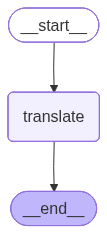

In [9]:
subgraph

In [10]:
class ParentState(TypedDict):
    question:str
    ans_eng:str
    ans_hin:str

In [11]:
def generate_answer(state: ParentState):

    answer = llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'ans_eng': answer}

In [12]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['ans_eng']})

    return {'ans_hin': result['translated_txt']}

In [14]:
graph = StateGraph(ParentState)

graph.add_node("answer", generate_answer)
graph.add_node("translate", translate_answer)

graph.add_edge(START,"answer")
graph.add_edge("answer","translate")
graph.add_edge("translate",END)

workflow = graph.compile()


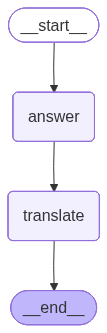

In [15]:
workflow

In [16]:
workflow.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'ans_eng': '**Quantum physics** (also called quantum mechanics or quantum theory) is the branch of physics that describes how nature behaves at the smallest scales—atoms, molecules, electrons, photons, and other sub‑atomic particles.  \n\n---\n\n## Core ideas\n\n| Concept | What it means | Everyday analogy (if any) |\n|---------|---------------|--------------------------|\n| **Quantization** | Certain physical quantities (energy, angular momentum, electric charge) can only take discrete “chunks” or *quanta* rather than a continuous range. | Like climbing a staircase: you can stand on the steps (allowed energies) but not in between. |\n| **Wave‑particle duality** | Particles such as electrons and photons exhibit both wave‑like and particle‑like behavior, depending on how you measure them. | Light can spread out like a ripple in water (interference) yet also hit a detector as individual packets (photons). |\n| **Superposition** | A quantum system 